---

# Atenção!

Lembre-se de clonar este notebook antes de tentar editar as células de código.

Para isso, basta seguir os passos:

File -> Save a copy in Drive



---

# Epílogo

## Estático _versus_ Dinâmico

Com a aula anterior aprendemos a lidar com o problema de organizar entregas em rotas que minimizam a distância total percorrida e respeitam as restrições operacionais de capacidade nos veículos. Isso significa que um dos problemas mais importantes da empresa já está resolvido. Certo?

Não exatamente. Existe uma limitação prática muito grande para empregar o algoritmo de VRP da aula passada: nós precisamos ter disponíveis informações de _todas_ as entregas antes de executá-lo.

Imagine que você possua um galpão em algum ponto da cidade onde aguarda diariamente caminhões com vários pacotes. Para usar os algoritmos de antes precisaríamos aguardar todos os caminhões chegarem, organizar as entregas de alguma forma no galpão, identificar suas propriedades (como endereço e dimensões), rodar algum dos solvers de antes, ler a resposta, e reorganizá-los em veículos para finalmente serem entregues.

Agora pense no quão praticável isso seria; e se os caminhões chegassem em horários imprevisíveis? Nós manteríamos toda a operação e os pacotes que já chegaram travados, e deixaríamos os motoristas aguardando? Além disso, existe a garantia de que o seu galpão comportaria todos os pacotes?

Em uma empresa grande como a Loggi, estas questões são problemáticas a ponto de que o algoritmo anterior não é aplicável diretamente. Idealmente deveríamos ser capazes de receber um pacote e alocá-lo o mais rápido possível a um veículo. Mas como não sabemos todos os pacotes que serão entregues, como garantir que as rotas serão boas no fim das contas?




Por exemplo, imagine que tenhamos 3 veículos disponíveis para entregar 5 pacotes, e até o momento três já chegaram. Cada veículo suporta no máximo 2 pacotes.

Decidimos colocar os dois primeiros no veículo 1, e o terceiro no veículo 2, como mostrado abaixo. Suponha agora que chegou o pacote 4. Em qual veículo seria melhor incluí-lo?







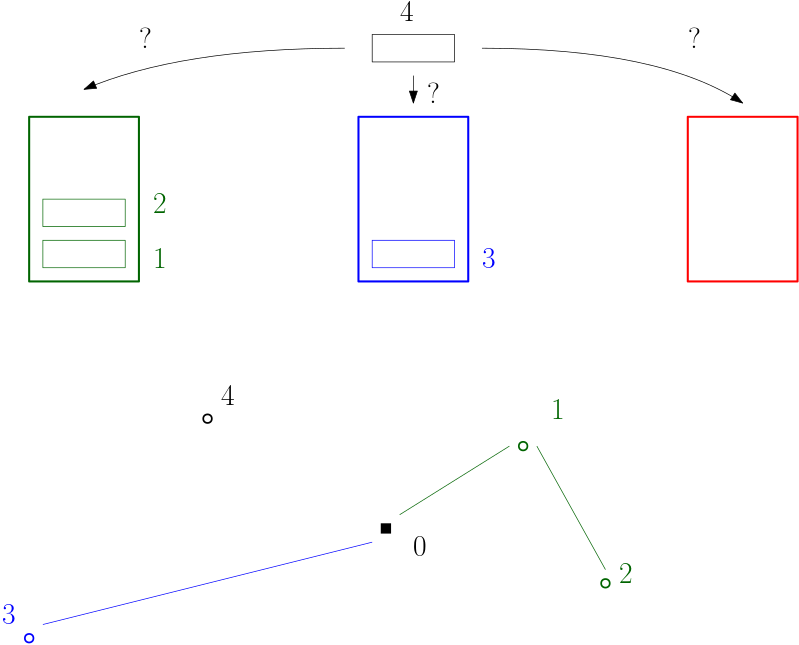

Colocar no veículo 1 não é possível, já que ele está no seu limite.

Podemos cogitar, então, incluí-lo nos veículos 2 ou 3. Qual dos dois seria uma opção melhor?


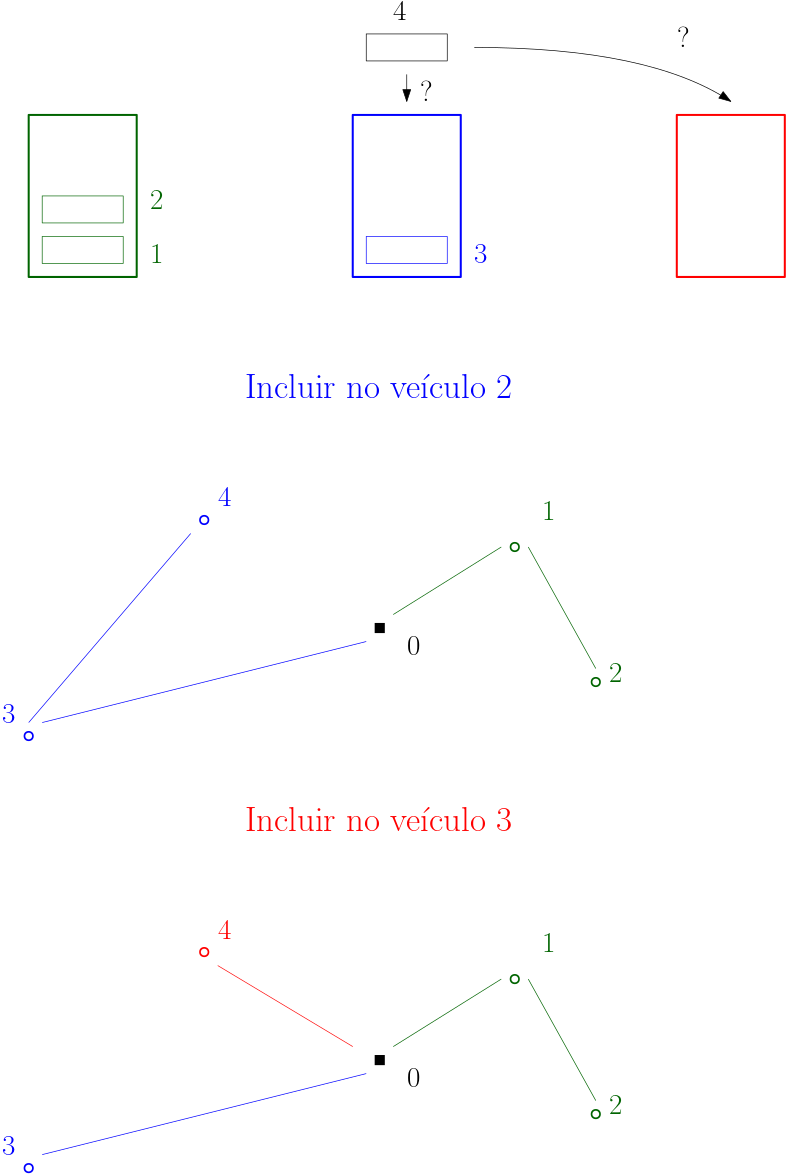

O problema aqui é que não sabemos onde estará o quinto pacote. Se ele estiver na localização abaixo, seria melhor ter incluído o Pacote 4 no terceiro veículo, já que assim as rotas ao todo seriam melhores e a distância total mais curta.


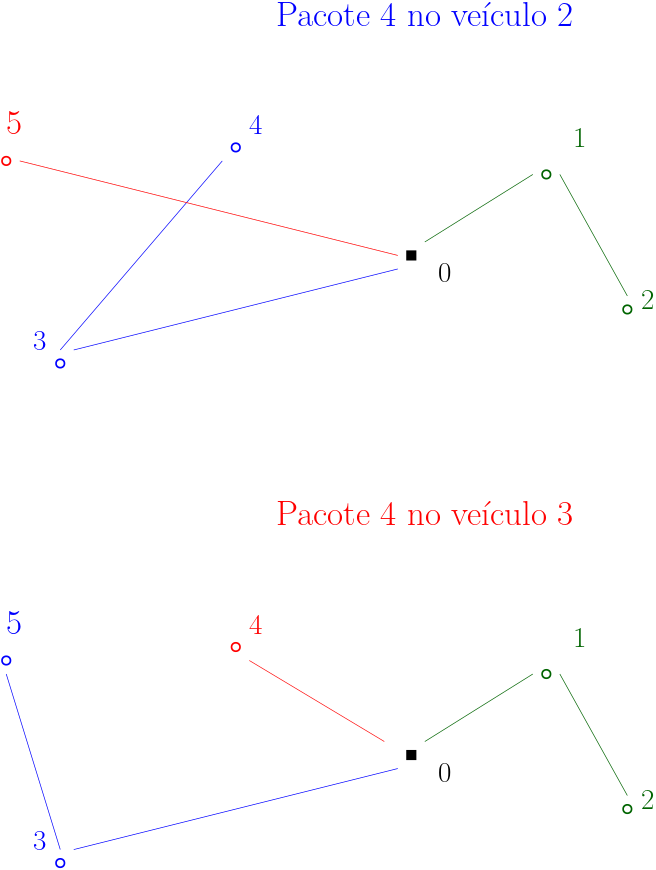

A grande dificuldade neste caso está na falta de informação _a priori_. Como não temos todos os dados disponíveis desde o início, precisamos de métodos adaptados para lidar com estas situações mais _dinâmicas_.

O problema tratado nas aulas passadas é normalmente conhecido na literatura como _Estático_, já que a informação completa dele está acessível desde o início e mantém-se a mesma. Em contrapartida, o exemplo dado acima descreve um problema _Dinâmico_, em que a informação vai tornando-se disponível com o tempo e precisamos de soluções à medida em que ela é apresentada.

A comunidade científica continua ativamente estudando ambos os tipos de problemas. Porém, a versão dinâmica está muito menos adiantada na disponibilidade de algoritmos e solvers considerados "estados da arte". Por isso, não vamos contar nesta aula exclusivamente com solvers prontos. A criatividade será um fator importante para resolvê-los.

# Um algoritmo ingênuo para o VRP dinâmico

## Preliminares
Nesta seção vamos resolver o VRP dinâmico relembrando o método ingênuo. O objetivo é para apenas fornecer uma noção da diferença de como os problemas são tratados.

Como antes, começamos baixando o projeto:

In [ ]:
!git clone https://github.com/loggi/loggibud
%cd /content/loggibud/

# Instale as dependências do projeto
!pip install poetry
!poetry install
# Se você estiver executando esse script localmente, não precisa dos dois comandos abaixo
!poetry export -f requirements.txt --without-hashes --output requirements.txt
!pip install -r requirements.txt

# Verifique se tudo funcionou executando os testes
!poetry run pytest -s -v tests/

# Baixe os dados compilados
!wget -nc https://loggibud.s3.amazonaws.com/dataset.zip
!unzip -n dataset.zip

# Verifique que a pasta `data/` agora não está mais vazia
!ls data/

Cloning into 'loggibud'...
remote: Enumerating objects: 967, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 967 (delta 45), reused 58 (delta 33), pack-reused 871
Receiving objects: 100% (967/967), 6.42 MiB | 11.61 MiB/s, done.
Resolving deltas: 100% (502/502), done.
/content/loggibud
     |████████████████████████████████| 175 kB 7.1 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 91 kB 13.2 MB/s 
     |████████████████████████████████| 40 kB 7.2 MB/s 
     |████████████████████████████████| 5.3 MB 51.1 MB/s 
     |████████████████████████████████| 424 kB 77.7 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 3.5 MB 63.4 MB/s 
     |████████████████████████████████| 496 kB 67.4 MB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.8.1
    Uninstalling importlib-metad

============================= test session starts ==============================
platform linux -- Python 3.7.12, pytest-6.2.4, py-1.10.0, pluggy-0.13.1 -- /root/.cache/pypoetry/virtualenvs/loggibud-3SbdMl6d-py3.7/bin/python
cachedir: .pytest_cache
rootdir: /content/loggibud
collected 7 items / 1 skipped / 6 selected                                     

tests/v1/test_data_conversion.py::test_can_create_proper_tsplib_from_instance PASSED
tests/v1/test_distances.py::test_great_circle_distance PASSED
tests/v1/test_distances.py::test_great_circle_route_distance PASSED
tests/v1/test_task1_baselines.py::test_ortools_solver PASSED
tests/v1/test_task1_baselines.py::test_lkh_solver PASSED
100% 158/158 [00:00<00:00, 2790.81it/s]
PASSED
100% 158/158 [00:00<00:00, 74949.11it/s]
PASSED

========================= 7 passed, 1 skipped in 8.13s =========================
--2021-10-19 13:18:20--  https://loggibud.s3.amazonaws.com/dataset.zip
Resolving loggibud.s3.amazonaws.com (loggibud.s3.amazonaws.com

In [ ]:
# Arquivo de configuração para acessar o OSRM
from loggibud.v1.distances import OSRMConfig


osrm_config = OSRMConfig(host="http://ec2-34-222-175-250.us-west-2.compute.amazonaws.com")
osrm_config

OSRMConfig(host='http://ec2-34-222-175-250.us-west-2.compute.amazonaws.com', timeout_s=600)

## Visão geral

Antes de começar a programar, é interessante relembrar como funciona nosso algoritmo ingênuo.

Considere novamente o nosso galpão. Assuma que os pacotes cheguem por caminhões em horários incertos, e há uma fila de motoristas aguardando para realizarem as entregas. Precisamos de uma regra que associe um pacote a um veículo assim que ele chega.

O nosso algoritmo funciona assim:

- Comece com um veículo vazio;
- Ao chegar um novo pacote, coloque-o neste veículo se houver espaço. Caso contrário, finalize esta rota e parta para o próximo veículo;
- Repita o processo até que todos os pacotes sejam processados.

Bem simples, certo? Para exemplificar, considere o seguinte problema com 8 entregas. Elas chegam na ordem 1, 2, 3, ..., 8, mas, claro, isto não é conhecido _a priori_ por nós. Imagine que temos 3 veículos disponíveis, cada um com capacidade para 3 pacotes.



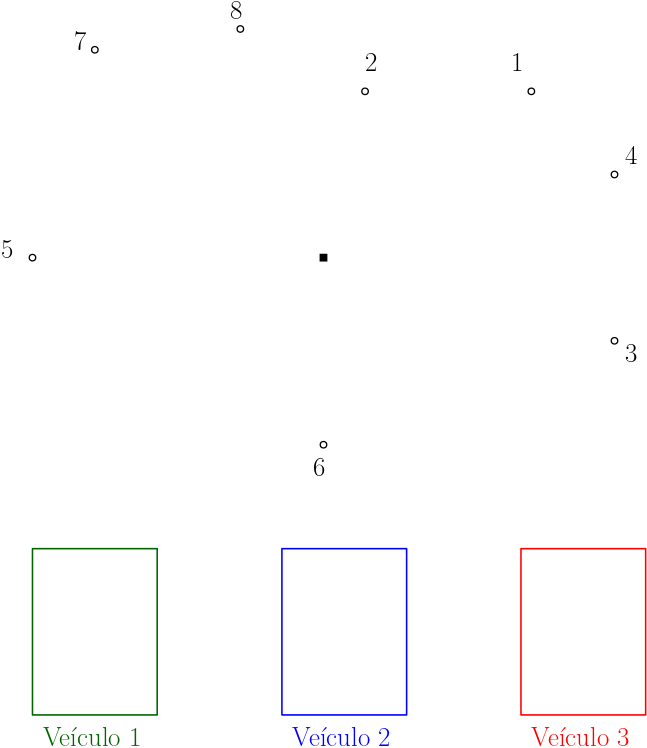

O que nosso algoritmo faria é:

1. Coloque o pacote 1 no veículo 1;
2. Coloque o próximo pacote 2 no veículo 1;
3. Coloque o pacote 3 no veículo 1;

A partir daí, o veículo 1 estaria cheio, e partiríamos para o próximo. No final das contas, nossas rotas seriam as seguintes:



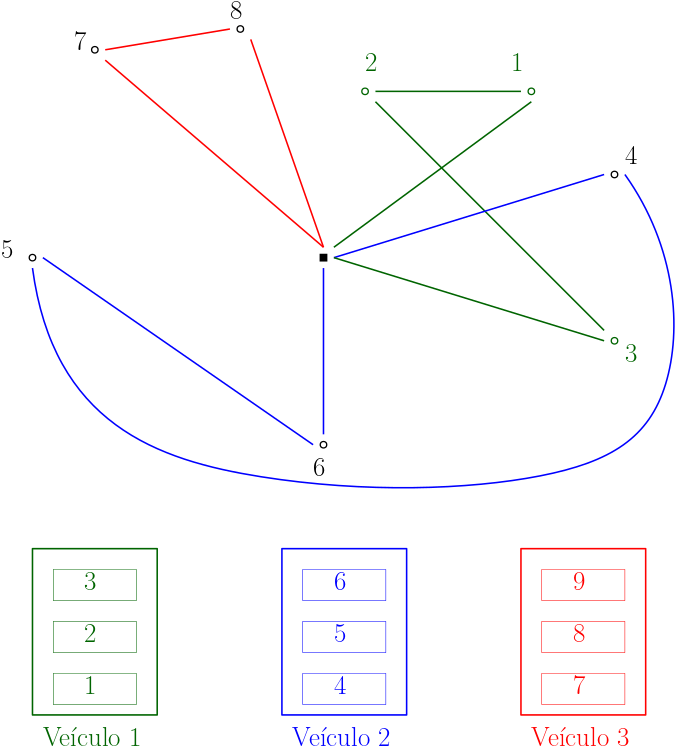

Observe os diversos problemas aqui. A rota do veículo 1 faz um zigue-zague desnecessário; e a rota 2 dá uma volta enorme, passando pelo nó 6 e voltando nele. Apenas a rota 3 parece satisfatória.

Em resumo, nós colocamos um pacote no primeiro veículo que houver. Este método não se importa em como as rotas ficarão no final das contas, apenas em satisfazer as restrições de capacidade e ser aplicável num contexto dinâmico. É uma abordagem bastante ruim, mas simples o suficiente para iniciarmos.

## Implementação

Vamos tratar da mesma instância da aula anterior por familiaridade:

In [ ]:
from loggibud.v1.types import CVRPInstance

file_path = "./data/cvrp-instances-1.0/train/df-0/cvrp-0-df-0.json"
problem = CVRPInstance.from_file(file_path)
problem

CVRPInstance(name='cvrp-0-df-0', region='df-0', origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), vehicle_capacity=180, deliveries=[Delivery(id='ed0993f8cc70d998342f38ee827176dc', point=Point(lng=-47.7496622016347, lat=-15.65879313293694), size=10), Delivery(id='c7220154adc7a3def8f0b2b8a42677a9', point=Point(lng=-47.75887552060412, lat=-15.651440380492554), size=10), Delivery(id='54e598b20ffa2707d01b1ac00942793f', point=Point(lng=-47.755018806591394, lat=-15.651207309372888), size=7), Delivery(id='64812681ba8c280649f764b9fb40936a', point=Point(lng=-47.758785390289965, lat=-15.648706444367969), size=3), Delivery(id='c17ea5bb3bdb1346ea358516cba81e5c', point=Point(lng=-47.75284167302011, lat=-15.66047286919706), size=10), Delivery(id='fb1b2bc2ac3783706de766e715cb9d01', point=Point(lng=-47.74788198106806, lat=-15.663388754816273), size=3), Delivery(id='c667f779151bd4e23e91d3b4659ffd94', point=Point(lng=-47.75836162961292, lat=-15.648355505737312), size=5), Delivery(id='7b315f

Para simplificar, vamos reduzir o problema para apenas as primeiras dez entregas:

In [ ]:
problem.deliveries = problem.deliveries[:10]
problem.deliveries

[Delivery(id='ed0993f8cc70d998342f38ee827176dc', point=Point(lng=-47.7496622016347, lat=-15.65879313293694), size=10),
 Delivery(id='c7220154adc7a3def8f0b2b8a42677a9', point=Point(lng=-47.75887552060412, lat=-15.651440380492554), size=10),
 Delivery(id='54e598b20ffa2707d01b1ac00942793f', point=Point(lng=-47.755018806591394, lat=-15.651207309372888), size=7),
 Delivery(id='64812681ba8c280649f764b9fb40936a', point=Point(lng=-47.758785390289965, lat=-15.648706444367969), size=3),
 Delivery(id='c17ea5bb3bdb1346ea358516cba81e5c', point=Point(lng=-47.75284167302011, lat=-15.66047286919706), size=10),
 Delivery(id='fb1b2bc2ac3783706de766e715cb9d01', point=Point(lng=-47.74788198106806, lat=-15.663388754816273), size=3),
 Delivery(id='c667f779151bd4e23e91d3b4659ffd94', point=Point(lng=-47.75836162961292, lat=-15.648355505737312), size=5),
 Delivery(id='7b315f77e3dfded7448866984942da14', point=Point(lng=-47.71947511765923, lat=-15.696661251647132), size=4),
 Delivery(id='5a1d00fc8dc1ee2a901740b5

E, claro, para não ficar tão simples, vamos reduzir a capacidade de cada veículo para 20, senão o nosso problema se tornaria um simples TSP já que um veículo seria mais que suficiente:

In [ ]:
problem.vehicle_capacity = 20
problem.vehicle_capacity

20

In [ ]:
# Veja estas entregas no mapa
from loggibud.v1.plotting.plot_instance import plot_cvrp_instance


plot_cvrp_instance(problem)
# Se estiver executando este código localmente num shell, complemente os
# seguintes passos
# plot_cvrp_instance(problem).save_to("map.html")
# Abra o arquivo `map.html` num navegador para ter a mesma experiência daqui

O que diferencia a versão dinâmica da estática é que os pacotes aqui chegam um por um, e na ordem em que estiverem na variável `problem.deliveries`. Assim, vamos simular suas chegadas com um `for`:

In [ ]:
for delivery in problem.deliveries:
    print(f"Recebemos o pacote {delivery}")

Recebemos o pacote Delivery(id='ed0993f8cc70d998342f38ee827176dc', point=Point(lng=-47.7496622016347, lat=-15.65879313293694), size=10)
Recebemos o pacote Delivery(id='c7220154adc7a3def8f0b2b8a42677a9', point=Point(lng=-47.75887552060412, lat=-15.651440380492554), size=10)
Recebemos o pacote Delivery(id='54e598b20ffa2707d01b1ac00942793f', point=Point(lng=-47.755018806591394, lat=-15.651207309372888), size=7)
Recebemos o pacote Delivery(id='64812681ba8c280649f764b9fb40936a', point=Point(lng=-47.758785390289965, lat=-15.648706444367969), size=3)
Recebemos o pacote Delivery(id='c17ea5bb3bdb1346ea358516cba81e5c', point=Point(lng=-47.75284167302011, lat=-15.66047286919706), size=10)
Recebemos o pacote Delivery(id='fb1b2bc2ac3783706de766e715cb9d01', point=Point(lng=-47.74788198106806, lat=-15.663388754816273), size=3)
Recebemos o pacote Delivery(id='c667f779151bd4e23e91d3b4659ffd94', point=Point(lng=-47.75836162961292, lat=-15.648355505737312), size=5)
Recebemos o pacote Delivery(id='7b315f7

O nosso solver irá trabalhar dentro deste `for`. Lembre que a nossa solução deve ser do tipo `CVRPSolution`, que tem uma lista de objetos do tipo `CVRPSolutionVehicle`.

Vamos fazer então o seguinte: começamos criando uma lista vazia `vehicle_deliveries = []`. Dentro do `for`, tentamos incluir o pacote atual nesta lista. Para isso, precisamos de uma função para calcular o volume atual de um veículo:

In [ ]:
def compute_vehicle_volume(vehicle_deliveries):
    volume = 0
    for delivery in vehicle_deliveries:
        volume += delivery.size
    return volume

# Teste com uma lista vazia e veja que seu volume deve ser 0
compute_vehicle_volume([])

0

In [ ]:
# Use este espaço para calcular aqui o volume de todas as entregas

Agora faremos o seguinte. Se o volume atual de um veículo mais o volume do pacote que está chegando for menor que a capacidade disponível, nós incluímos o pacote. Caso contrário, a rota está finalizada e partimos para o próximo veículo vazio.



In [ ]:
vehicle_deliveries = []
for delivery in problem.deliveries:
    if compute_vehicle_volume(vehicle_deliveries) + delivery.size <= problem.vehicle_capacity:
        print("Veículo disponível.")
        vehicle_deliveries.append(delivery)
    else:
        print("Veículo cheio.")

Veículo disponível.
Veículo disponível.
Veículo cheio.
Veículo cheio.
Veículo cheio.
Veículo cheio.
Veículo cheio.
Veículo cheio.
Veículo cheio.
Veículo cheio.


Como vemos, nosso primeiro veículo poderia conter as duas primeiras entregas. (Observe nas células anteriores como as duas juntas somam 20 de volume, o que faz sentido)

Vamos fazer o seguinte então: vamos criar uma variável `vehicles = []`, que armazenará todas as rotas. Cada vez que um veículo ficar cheio, nós o incluímos em `vehicles` e criamos um novo.

Veja o código a seguir para melhor entender a ideia:

In [ ]:
vehicles = []  # lista com todos os veículos
vehicle_deliveries = []  # inicializa o primeiro veículo vazio
for delivery in problem.deliveries:
    if compute_vehicle_volume(vehicle_deliveries) + delivery.size <= problem.vehicle_capacity:
        print("Veículo disponível.")
        vehicle_deliveries.append(delivery)
    else:
        print("Veículo cheio. Finalizando a rota e incluindo o pacote em outro")
        vehicles.append(vehicle_deliveries)
        vehicle_deliveries = [delivery]  # inicializa novo veículo com o pacote atual
vehicles

Veículo disponível.
Veículo disponível.
Veículo cheio. Finalizando a rota e incluindo o pacote em outro
Veículo disponível.
Veículo disponível.
Veículo cheio. Finalizando a rota e incluindo o pacote em outro
Veículo disponível.
Veículo disponível.
Veículo disponível.
Veículo disponível.


[[Delivery(id='ed0993f8cc70d998342f38ee827176dc', point=Point(lng=-47.7496622016347, lat=-15.65879313293694), size=10),
  Delivery(id='c7220154adc7a3def8f0b2b8a42677a9', point=Point(lng=-47.75887552060412, lat=-15.651440380492554), size=10)],
 [Delivery(id='54e598b20ffa2707d01b1ac00942793f', point=Point(lng=-47.755018806591394, lat=-15.651207309372888), size=7),
  Delivery(id='64812681ba8c280649f764b9fb40936a', point=Point(lng=-47.758785390289965, lat=-15.648706444367969), size=3),
  Delivery(id='c17ea5bb3bdb1346ea358516cba81e5c', point=Point(lng=-47.75284167302011, lat=-15.66047286919706), size=10)]]

Ops! Segundo o histórico dos prints finalizamos duas rotas, e os quatro últimos pacotes ficaram num terceiro veículo. Porém, nossa variável `vehicles` contém apenas dois. Nós nos esquecemos de incluir o último veículo, mesmo que não esteja completamente cheio:

In [ ]:
vehicles = []  # lista com todos os veículos
vehicle_deliveries = []  # inicializa o primeiro veículo vazio
for delivery in problem.deliveries:
    if compute_vehicle_volume(vehicle_deliveries) + delivery.size <= problem.vehicle_capacity:
        print("Veículo disponível.")
        vehicle_deliveries.append(delivery)
    else:
        print("Veículo cheio. Incluindo os pacotes em um novo")
        vehicles.append(vehicle_deliveries)
        vehicle_deliveries = [delivery]  # inicializa novo veículo com o pacote atual

# Inclui o último veículo se contiver algum pacote
if vehicle_deliveries:
    vehicles.append(vehicle_deliveries)
vehicles


Veículo disponível.
Veículo disponível.
Veículo cheio. Incluindo os pacotes em um novo
Veículo disponível.
Veículo disponível.
Veículo cheio. Incluindo os pacotes em um novo
Veículo disponível.
Veículo disponível.
Veículo disponível.
Veículo disponível.


[[Delivery(id='ed0993f8cc70d998342f38ee827176dc', point=Point(lng=-47.7496622016347, lat=-15.65879313293694), size=10),
  Delivery(id='c7220154adc7a3def8f0b2b8a42677a9', point=Point(lng=-47.75887552060412, lat=-15.651440380492554), size=10)],
 [Delivery(id='54e598b20ffa2707d01b1ac00942793f', point=Point(lng=-47.755018806591394, lat=-15.651207309372888), size=7),
  Delivery(id='64812681ba8c280649f764b9fb40936a', point=Point(lng=-47.758785390289965, lat=-15.648706444367969), size=3),
  Delivery(id='c17ea5bb3bdb1346ea358516cba81e5c', point=Point(lng=-47.75284167302011, lat=-15.66047286919706), size=10)],
 [Delivery(id='fb1b2bc2ac3783706de766e715cb9d01', point=Point(lng=-47.74788198106806, lat=-15.663388754816273), size=3),
  Delivery(id='c667f779151bd4e23e91d3b4659ffd94', point=Point(lng=-47.75836162961292, lat=-15.648355505737312), size=5),
  Delivery(id='7b315f77e3dfded7448866984942da14', point=Point(lng=-47.71947511765923, lat=-15.696661251647132), size=4),
  Delivery(id='5a1d00fc8dc1e

Agora sim. Para este problema precisaríamos de três veículos. Observe como seus volumes não violam suas capacidades, como esperado.

Uma vez que a ideia está bem desenvolvida, precisamos apenas melhorar o código para retornar uma solução do tipo `CVRPSolution`.

Para isso, criamos uma função que converte uma lista `vehicle_deliveries` em uma variável do tipo `CVRPSolutionVehicle` cada vez que uma rota é finalizada:

In [ ]:
from loggibud.v1.types import CVRPSolutionVehicle


def _construct_vehicle(problem, vehicle_deliveries):
    return CVRPSolutionVehicle(
        origin=problem.origin, deliveries=vehicle_deliveries
    )

# Experimente com o último `vehicle_deliveries` retornado
_construct_vehicle(problem, vehicle_deliveries)

CVRPSolutionVehicle(origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), deliveries=[Delivery(id='fb1b2bc2ac3783706de766e715cb9d01', point=Point(lng=-47.74788198106806, lat=-15.663388754816273), size=3), Delivery(id='c667f779151bd4e23e91d3b4659ffd94', point=Point(lng=-47.75836162961292, lat=-15.648355505737312), size=5), Delivery(id='7b315f77e3dfded7448866984942da14', point=Point(lng=-47.71947511765923, lat=-15.696661251647132), size=4), Delivery(id='5a1d00fc8dc1ee2a901740b55cdd36aa', point=Point(lng=-47.76340110906013, lat=-15.668974870973102), size=1), Delivery(id='eebf0d97e6829796d7c012d3d0765647', point=Point(lng=-47.75482460546861, lat=-15.65435446002705), size=1)])

Assim, podemos finalizar nossa lógica:

In [ ]:
from loggibud.v1.types import CVRPSolution


vehicles = []  # lista com todos os veículos
vehicle_deliveries = []  # inicializa o primeiro veículo vazio
for delivery in problem.deliveries:
    if compute_vehicle_volume(vehicle_deliveries) + delivery.size <= problem.vehicle_capacity:
        print("Veículo disponível.")
        vehicle_deliveries.append(delivery)
    else:
        print("Veículo cheio. Incluindo os pacotes em um novo")
        vehicle_solution = _construct_vehicle(problem, vehicle_deliveries)
        vehicles.append(vehicle_solution)
        vehicle_deliveries = [delivery]  # inicializa novo veículo com o pacote atual

# Complete a rota do veículo final que sobrou
if vehicle_deliveries:
    vehicle_solution = _construct_vehicle(problem, vehicle_deliveries)
    vehicles.append(vehicle_solution)

# Ao final, retorne uma variável do tipo `CVRPSolution`
solution = CVRPSolution(name=problem.name, vehicles=vehicles)
solution

Veículo disponível.
Veículo disponível.
Veículo cheio. Incluindo os pacotes em um novo
Veículo disponível.
Veículo disponível.
Veículo cheio. Incluindo os pacotes em um novo
Veículo disponível.
Veículo disponível.
Veículo disponível.
Veículo disponível.


CVRPSolution(name='cvrp-0-df-0', vehicles=[CVRPSolutionVehicle(origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), deliveries=[Delivery(id='ed0993f8cc70d998342f38ee827176dc', point=Point(lng=-47.7496622016347, lat=-15.65879313293694), size=10), Delivery(id='c7220154adc7a3def8f0b2b8a42677a9', point=Point(lng=-47.75887552060412, lat=-15.651440380492554), size=10)]), CVRPSolutionVehicle(origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), deliveries=[Delivery(id='54e598b20ffa2707d01b1ac00942793f', point=Point(lng=-47.755018806591394, lat=-15.651207309372888), size=7), Delivery(id='64812681ba8c280649f764b9fb40936a', point=Point(lng=-47.758785390289965, lat=-15.648706444367969), size=3), Delivery(id='c17ea5bb3bdb1346ea358516cba81e5c', point=Point(lng=-47.75284167302011, lat=-15.66047286919706), size=10)]), CVRPSolutionVehicle(origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), deliveries=[Delivery(id='fb1b2bc2ac3783706de766e715cb9d01', point=Point(lng=-47.

In [ ]:
# Verifique aqui se a solução parece correta, observando o número de veículos e se todos os pacotes estão presentes

Como temos uma legítima variável de solução, podemos aproveitar as funcionalidades presentes no repositório, como avaliar sua solução e plotar seus resultados. No caso, todo nosso percurso tem um total de cerca de 80km.

In [ ]:
from loggibud.v1.eval.task1 import evaluate_solution


evaluate_solution(problem, solution, config=osrm_config)

80.7001

Aqui está um exemplo de como as rotas finais ficaram. Observe como a rota preta ficou até razoável, enquanto as outras apresentaram um zigue-zague, como esperado.

In [ ]:
from loggibud.v1.plotting.plot_solution import plot_cvrp_solution, plot_cvrp_solution_routes


plot_cvrp_solution(solution)

In [ ]:
# Se preferir, desenhe as rotas em rua para ter outra visão do caminho seguido
plot_cvrp_solution_routes(solution, config=osrm_config)

In [ ]:
# Caso pareça confuso, desenhe uma rota de cada vez alternando o índice do
# veículo na variável `route_indices_to_plot`
plot_cvrp_solution_routes(solution, config=osrm_config, route_indices_to_plot=[1])

Com tudo isso entendido, aqui está o código completo do nosso solver, em que transformamos as funções anteriores em subfunções e removemos os prints:

In [ ]:
from loggibud.v1.types import CVRPSolution, CVRPSolutionVehicle


def solve_vrp_naive_algorithm(problem):
    vehicles = []  # lista com todos os veículos
    vehicle_deliveries = []  # inicializa o primeiro veículo vazio
    for delivery in problem.deliveries:
        if (
            _compute_vehicle_volume(vehicle_deliveries) + delivery.size
            <= problem.vehicle_capacity
        ):
            vehicle_deliveries.append(delivery)
        else:
            vehicle_solution = _construct_vehicle(problem, vehicle_deliveries)
            vehicles.append(vehicle_solution)
            # Inicializa novo veículo com o pacote atual
            vehicle_deliveries = [delivery]

    # Complete a rota do veículo final que sobrou
    if vehicle_deliveries:
        vehicle_solution = _construct_vehicle(problem, vehicle_deliveries)
        vehicles.append(vehicle_solution)

    # Ao final, retorne uma variável do tipo `CVRPSolution`
    return CVRPSolution(name=problem.name, vehicles=vehicles)


def _compute_vehicle_volume(deliveries):
    volume = 0
    for delivery in deliveries:
        volume += delivery.size
    return volume


def _construct_vehicle(problem, vehicle_deliveries):
    return CVRPSolutionVehicle(
        origin=problem.origin, deliveries=vehicle_deliveries
    )


Analise bem este código para entender o que é feito.

Depois disso, rode novamente com nosso problema simplificado:

In [ ]:
solution = solve_vrp_naive_algorithm(problem)
solution

CVRPSolution(name='cvrp-0-df-0', vehicles=[CVRPSolutionVehicle(origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), deliveries=[Delivery(id='ed0993f8cc70d998342f38ee827176dc', point=Point(lng=-47.7496622016347, lat=-15.65879313293694), size=10), Delivery(id='c7220154adc7a3def8f0b2b8a42677a9', point=Point(lng=-47.75887552060412, lat=-15.651440380492554), size=10)]), CVRPSolutionVehicle(origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), deliveries=[Delivery(id='54e598b20ffa2707d01b1ac00942793f', point=Point(lng=-47.755018806591394, lat=-15.651207309372888), size=7), Delivery(id='64812681ba8c280649f764b9fb40936a', point=Point(lng=-47.758785390289965, lat=-15.648706444367969), size=3), Delivery(id='c17ea5bb3bdb1346ea358516cba81e5c', point=Point(lng=-47.75284167302011, lat=-15.66047286919706), size=10)]), CVRPSolutionVehicle(origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), deliveries=[Delivery(id='fb1b2bc2ac3783706de766e715cb9d01', point=Point(lng=-47.

Experimente plotar novamente estas soluções e agora avaliá-las com a função `evaluate_solution`. Após isso, tente executar com a instância completa (Exercício 1).

## Melhorando as rotas com o TSP



Um dos grandes problemas que temos com nosso algoritmo ingênuo é a quantidade de zigue-zagues das nossas rotas. Isso é proveniente não só da má escolha de pacotes em um veículo, mas também da _ordem_ com que são entregues, já que até o momento seguimos as posições em que eles chegam.

Felizmente, se relembrarmos nossas aulas anteriores, podemos fazer uso do Problema do Caixeiro Viajante (TPS) para melhorar ao menos a ordem com que os pacotes são entregues cada vez que uma rota é completa.

Aqui está o código do solver que desenvolvemos na aula do TSP (optamos pela versão do OR-Tools pelo número esperado de entregas poder ser muito grande):

In [ ]:
import numpy as np
from ortools.constraint_solver import pywrapcp


def solve_tsp_ortools(distance_matrix):
    n = distance_matrix.shape[0]  # número de nós do problema
    num_vehicles = 1  # número de veículos (no nosso caso, apenas um)
    depot_node = 0  # número do nó que representa o ponto de origem
    manager = pywrapcp.RoutingIndexManager(n, num_vehicles, depot_node)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(i, j):
        # `i` e `j` são índices internos do OR-Tools. Precisamos primeiro
        # convertê-los em nós do nosso problema
        ni = manager.IndexToNode(i)
        nj = manager.IndexToNode(j)
        return distance_matrix[ni, nj]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Resolve o problema com métodos default
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    solution = routing.SolveWithParameters(search_parameters)

    # Constroi a rota final
    route = []
    index = routing.Start(0)
    node = manager.IndexToNode(index)
    route.append(node)

    while not routing.IsEnd(index):
        index = solution.Value(routing.NextVar(index))
        node = manager.IndexToNode(index)
        route.append(node)

    return route, solution.ObjectiveValue()

O que precisamos fazer é rodar este código no momento em que um pacote não couber mais em um veículo e sua rota for fechada.

Antes disso, precisamos de uma função para calcular a matriz de distâncias dos pontos em uma rota:

In [ ]:
from loggibud.v1.distances import calculate_distance_matrix_m, OSRMConfig


def _compute_distance_matrix(problem, vehicle_deliveries):
    # Os pontos do problema consistem na origem mais as entregas em `vehicle_deliveries`
    points = [problem.origin]
    for delivery in vehicle_deliveries:
        points.append(delivery.point)

    return calculate_distance_matrix_m(points, config=osrm_config)


# Experimente com nosso último `vehicle_deliveries`
_compute_distance_matrix(problem, vehicle_deliveries)


array([[    0. ,  8947.4,  6960. , 16912.4,  8762.1,  7711.3],
       [ 8580.1,     0. ,  3113.7,  8868.7,  2680.1,  2215.1],
       [ 6283.6,  3211. ,     0. , 11176. ,  3025.6,  1974.9],
       [16576.2,  8868.7, 11109.9,     0. , 10676.3, 10211.2],
       [ 8498.8,  2617.7,  3032.4, 10582.7,     0. ,  2133.8],
       [ 7441.2,  2312.3,  1974.9, 10277.3,  2127. ,     0. ]])

Assim, podemos adaptar nossa função `_construct_vehicle` para calcular essa matriz e executar o TSP:

In [ ]:
def _construct_vehicle(problem, vehicle_deliveries):
    distance_matrix = _compute_distance_matrix(problem, vehicle_deliveries)
    ordered_indices, _ = solve_tsp_ortools(distance_matrix)

    # `ordered_indices` tem o formato `[0, 4, 3, 1, ..., 0]`. Precisamos remover
    # a origem do início e do final e ordenar a variável `vehicle_deliveries` usando estes
    # índices
    ordered_vehicle_deliveries = []
    for ordered_index in ordered_indices[1:-1]:
        ordered_vehicle_deliveries.append(vehicle_deliveries[ordered_index - 1])

    return CVRPSolutionVehicle(origin=problem.origin, deliveries=ordered_vehicle_deliveries)

# Vamos testar com nosso `vehicle_deliveries`
ordered_vehicle_deliveries = _construct_vehicle(problem, vehicle_deliveries)
ordered_vehicle_deliveries

CVRPSolutionVehicle(origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), deliveries=[Delivery(id='5a1d00fc8dc1ee2a901740b55cdd36aa', point=Point(lng=-47.76340110906013, lat=-15.668974870973102), size=1), Delivery(id='7b315f77e3dfded7448866984942da14', point=Point(lng=-47.71947511765923, lat=-15.696661251647132), size=4), Delivery(id='fb1b2bc2ac3783706de766e715cb9d01', point=Point(lng=-47.74788198106806, lat=-15.663388754816273), size=3), Delivery(id='eebf0d97e6829796d7c012d3d0765647', point=Point(lng=-47.75482460546861, lat=-15.65435446002705), size=1), Delivery(id='c667f779151bd4e23e91d3b4659ffd94', point=Point(lng=-47.75836162961292, lat=-15.648355505737312), size=5)])

Estude bem esta função, e se necessário, execute-a diversas vezes com prints no meio do código para ver o que cada variável significa.

Como há poucos nós no nosso problema adaptado, compare `vehicle_deliveries` com `ordered_vehicle_deliveries` se necessário.

Aqui está a versão completa do nosso algoritmo ingênuo usando o TSP:

In [ ]:
from loggibud.v1.distances import calculate_distance_matrix_m, OSRMConfig
from loggibud.v1.types import CVRPSolution, CVRPSolutionVehicle


def solve_vrp_naive_algorithm_with_tsp(problem):
    vehicles = []  # lista com todos os veículos
    vehicle_deliveries = []  # inicializa o primeiro veículo vazio
    for delivery in problem.deliveries:
        if (
            _compute_vehicle_volume(vehicle_deliveries) + delivery.size
            <= problem.vehicle_capacity
        ):
            vehicle_deliveries.append(delivery)
        else:
            vehicle_solution = _construct_vehicle(problem, vehicle_deliveries)
            vehicles.append(vehicle_solution)
            # Inicializa novo veículo com o pacote atual
            vehicle_deliveries = [delivery]

    # Complete a rota do veículo final que sobrou
    if vehicle_deliveries:
        vehicle_solution = _construct_vehicle(problem, vehicle_deliveries)
        vehicles.append(vehicle_solution)

    # Ao final, retorne uma variável do tipo `CVRPSolution`
    return CVRPSolution(name=problem.name, vehicles=vehicles)


def _compute_vehicle_volume(deliveries):
    volume = 0
    for delivery in deliveries:
        volume += delivery.size
    return volume


def _construct_vehicle(problem, vehicle_deliveries):
    distance_matrix = _compute_distance_matrix(problem, vehicle_deliveries)
    ordered_indices, _ = solve_tsp_ortools(distance_matrix)

    # `ordered_indices` tem o formato `[0, 4, 3, 1, ..., 0]`. Precisamos
    # remover a origem do início e do final e ordenar a variável
    # `vehicle_deliveries` usando estes índices
    ordered_vehicle_deliveries = []
    for ordered_index in ordered_indices[1:-1]:
        ordered_vehicle_deliveries.append(
            vehicle_deliveries[ordered_index - 1]
        )

    return CVRPSolutionVehicle(
        origin=problem.origin, deliveries=ordered_vehicle_deliveries
    )


def _compute_distance_matrix(problem, vehicle_deliveries):
    # Os pontos do problema consistem na origem mais as entregas em
    # `vehicle_deliveries`
    points = [problem.origin]
    for delivery in vehicle_deliveries:
        points.append(delivery.point)

    return calculate_distance_matrix_m(points, config=osrm_config)


In [ ]:
# Teste novamente com nosso problema adaptado
solution = solve_vrp_naive_algorithm_with_tsp(problem)
solution

CVRPSolution(name='cvrp-0-df-0', vehicles=[CVRPSolutionVehicle(origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), deliveries=[Delivery(id='c7220154adc7a3def8f0b2b8a42677a9', point=Point(lng=-47.75887552060412, lat=-15.651440380492554), size=10), Delivery(id='ed0993f8cc70d998342f38ee827176dc', point=Point(lng=-47.7496622016347, lat=-15.65879313293694), size=10)]), CVRPSolutionVehicle(origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), deliveries=[Delivery(id='c17ea5bb3bdb1346ea358516cba81e5c', point=Point(lng=-47.75284167302011, lat=-15.66047286919706), size=10), Delivery(id='54e598b20ffa2707d01b1ac00942793f', point=Point(lng=-47.755018806591394, lat=-15.651207309372888), size=7), Delivery(id='64812681ba8c280649f764b9fb40936a', point=Point(lng=-47.758785390289965, lat=-15.648706444367969), size=3)]), CVRPSolutionVehicle(origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), deliveries=[Delivery(id='5a1d00fc8dc1ee2a901740b55cdd36aa', point=Point(lng=-47.

In [ ]:
# Distância total de todas as rotas
evaluate_solution(problem, solution, config=osrm_config)

74.8348

In [ ]:
# Desenhe a solução novamente
plot_cvrp_solution(solution)

Observe como o zigue-zague anterior foi removido, e apenas com esta adição nosso algoritmo tornou-se bem mais eficiente. No caso, nossa distância total caiu cerca de 5km.

Experimente plotar as rotas em rua como na seção anterior, e em seguida, resolva novamente o problema com a instância completa (Exercício 2).

# Um algoritmo construtivo para o VRP dinâmico

Como mencionamos no início desta aula, no caso dinâmico não contamos com a gama de métodos disponíveis para resolver o VRP como existe com o caso estático. Assim, precisamos depender de nossa criatividade.

Na última seção implementamos um método trivial apenas para nos familiarizarmos com o código e visualizarmos as soluções. Vimos como este método tende a não ser eficiente por ignorar os pacotes que já chegaram e colocar tudo na primeira opção disponível. Vamos aqui apresentar uma outra sugestão mais elaborada.

## Visão geral


A ideia do nosso algoritmo é construir rotas deixando os pacotes o mais próximos o possível, e assim tentar evitar aberrações.

Imagine que temos 4 veículos disponíveis, cada um suportando 3 pacotes.

Em um momento, 6 pacotes já chegaram e foram atribuídos a três dos veículos como mostrado abaixo:



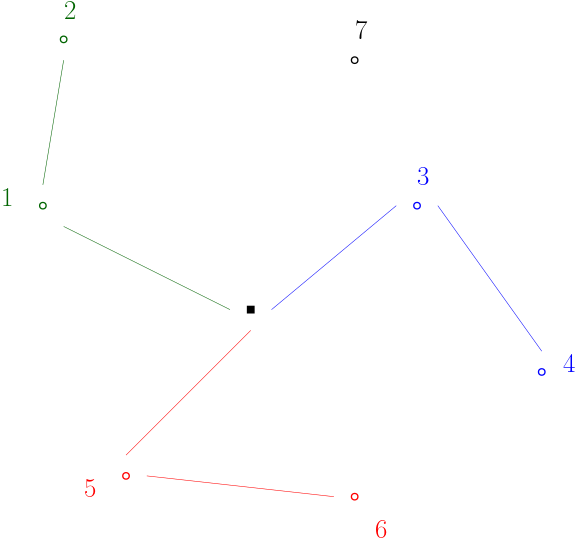

Assuma que chegou o sétimo pacote. Para qual veículo ele deve ser alocado?

Nosso algoritmo funciona assim:
1. Filtre os veículos que suportariam a inclusão do pacote 7. Neste caso, nenhum está completamente cheio;
2. Dentre os veículos restantes, calcule a distância do pacote 7 a cada um dos outros, incluindo a origem;
3. Determine o pacote mais próximo de 7. Atribua-o ao veículo correspondente. Se a origem for mais próxima, coloque-o num novo veículo vazio.

Neste exemplo, 7 está mais próximo do pacote 3, então ele seria adicionado ao veículo azul.



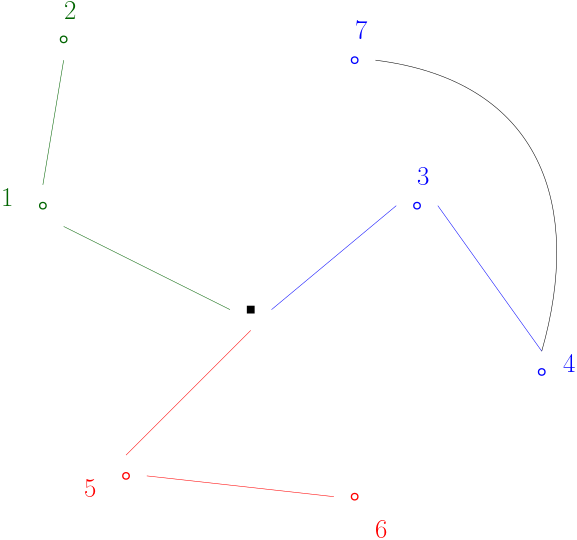

Não se preocupe se a rota atualmente parecer ruim. Quando o veículo estiver cheio nós a corrigimos com o poder do TSP conforme descrito na seção anterior.

Prossiga com o método até que todos os pacotes sejam ordenados.

## Implementação


Lembre que nosso código deve ser feito dentro do seguinte `for`:

```python
for delivery in problem.deliveries:
    print(f"Recebemos o pacote {delivery}")
```

A primeira coisa de que precisamos é uma função para filtrar os veículos com espaço disponível para caber um pacote:

In [ ]:
def _filter_available_vehicles(problem, vehicles, delivery):
    """
    Filtra os veículos com volume restante suficiente para caber um novo pacote
    """
    available_vehicles = []
    for vehicle in vehicles:
        if _compute_vehicle_volume(vehicle) + delivery.size <= problem.vehicle_capacity:
            available_vehicles.append(vehicle)

    return available_vehicles

Esta função não deveria ser complicada de entender depois do código anterior. Observe que usamos a mesma função `_compute_vehicle_volume` construída antes.

Agora, dados os veículos disponíveis, calculamos a distância de uma nova entrega até todas as que estão atualmente, incluindo a origem. Isto é um pouco mais complexo do que parece, porque `vehicles` é uma lista de listas, e deveríamos não só expandir todos os elementos desta lista, mas também guardar qual elemento pertence a qual lista.

Vamos usar a lista de veículos que temos retornada do código anterior:

In [ ]:
vehicles

[CVRPSolutionVehicle(origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), deliveries=[Delivery(id='ed0993f8cc70d998342f38ee827176dc', point=Point(lng=-47.7496622016347, lat=-15.65879313293694), size=10), Delivery(id='c7220154adc7a3def8f0b2b8a42677a9', point=Point(lng=-47.75887552060412, lat=-15.651440380492554), size=10)]),
 CVRPSolutionVehicle(origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), deliveries=[Delivery(id='54e598b20ffa2707d01b1ac00942793f', point=Point(lng=-47.755018806591394, lat=-15.651207309372888), size=7), Delivery(id='64812681ba8c280649f764b9fb40936a', point=Point(lng=-47.758785390289965, lat=-15.648706444367969), size=3), Delivery(id='c17ea5bb3bdb1346ea358516cba81e5c', point=Point(lng=-47.75284167302011, lat=-15.66047286919706), size=10)]),
 CVRPSolutionVehicle(origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), deliveries=[Delivery(id='fb1b2bc2ac3783706de766e715cb9d01', point=Point(lng=-47.74788198106806, lat=-15.663388754816273)

O seguinte código é usado para expandir esta lista de listas e extrair as coordenadas de cada entrega:

In [ ]:
points = []
for vehicle in vehicles:
    for delivery in vehicle.deliveries:
        points.append(delivery.point)

points

[Point(lng=-47.7496622016347, lat=-15.65879313293694),
 Point(lng=-47.75887552060412, lat=-15.651440380492554),
 Point(lng=-47.755018806591394, lat=-15.651207309372888),
 Point(lng=-47.758785390289965, lat=-15.648706444367969),
 Point(lng=-47.75284167302011, lat=-15.66047286919706),
 Point(lng=-47.74788198106806, lat=-15.663388754816273),
 Point(lng=-47.75836162961292, lat=-15.648355505737312),
 Point(lng=-47.71947511765923, lat=-15.696661251647132),
 Point(lng=-47.76340110906013, lat=-15.668974870973102),
 Point(lng=-47.75482460546861, lat=-15.65435446002705)]

Claro, além disso, precisamos saber em qual veículo cada entrega pertence. Para isso, vamos usar outra lista `vehicle_numbers` com o mesmo número de elementos de `points` mas com o índice do seu veículo.

Analise o código abaixo (observe o uso de `enumerate` para armazenar o índice):

In [ ]:
points = []
vehicle_numbers = []
for i, vehicle in enumerate(vehicles):
    for delivery in vehicle.deliveries:
        points.append(delivery.point)
        vehicle_numbers.append(i)

points, vehicle_numbers

([Point(lng=-47.7496622016347, lat=-15.65879313293694),
  Point(lng=-47.75887552060412, lat=-15.651440380492554),
  Point(lng=-47.755018806591394, lat=-15.651207309372888),
  Point(lng=-47.758785390289965, lat=-15.648706444367969),
  Point(lng=-47.75284167302011, lat=-15.66047286919706),
  Point(lng=-47.74788198106806, lat=-15.663388754816273),
  Point(lng=-47.75836162961292, lat=-15.648355505737312),
  Point(lng=-47.71947511765923, lat=-15.696661251647132),
  Point(lng=-47.76340110906013, lat=-15.668974870973102),
  Point(lng=-47.75482460546861, lat=-15.65435446002705)],
 [0, 0, 1, 1, 1, 2, 2, 2, 2, 2])

Isto significa que os dois primeiros pontos estão no veículo 0, os três em diante no veículo 2, e assim por diante.

Com isso, basta adicionar a origem a e a entrega atual a `points` e calcular a matriz de distâncias:

In [ ]:
from loggibud.v1.distances import calculate_distance_matrix_m, OSRMConfig


def _compute_delivery_distance_from_vehicles(problem, available_vehicles, delivery):
    """
    Calcula a distância de `delivery` à origem e a cada pacote dos veículos
    disponíveis e retorna o veículo mais próximo.
    """

    # Inicializa `points` com a entrega atual e a origem
    # Inicializa também `vehicle_numbers` com -1 já que estes pontos não
    # percentem a nenhum veículos
    points = [delivery.point, problem.origin]
    vehicle_numbers = [-1, -1]

    # Extrai os pontos de cada veículos
    for i, vehicle in enumerate(vehicles):
        for delivery in vehicle.deliveries:
            points.append(delivery.point)
            vehicle_numbers.append(i)

    # Calcula a matriz de distâncias
    distance_matrix = calculate_distance_matrix_m(points, config=osrm_config)
    return distance_matrix

# Vamos ver o que temos até o momento supondo que os veículos atuais estão disponíveis
# Vamos testar com a última entrega
delivery = problem.deliveries[-1]
distance_matrix = _compute_delivery_distance_from_vehicles(problem, vehicles, delivery)
distance_matrix

array([[    0. ,  7441.2,  1968.5,  1445.8,  2075.3,  1947.3,  1598.6,
         2312.3,  1974.9, 10277.3,  2127. ,     0. ],
       [ 7711.3,     0. ,  8603.6,  7366.1,  7702.8,  6932.4,  8233.7,
         8947.4,  6960. , 16912.4,  8762.1,  7711.3],
       [ 1902.4,  8267.5,     0. ,  2272. ,  2901.5,  2773.5,   728.1,
         2181.8,  2801.1, 10146.8,  2367.5,  1902.4],
       [ 1445.8,  7096. ,  2338.1,     0. ,   940.4,   501.5,  1968.2,
         2681.9,   529.1, 10646.9,  2496.6,  1445.8],
       [ 2033.4,  7197.5,  2925.7,   884.5,     0. ,  1059.2,  2555.7,
         3269.5,  1086.8, 11234.5,  3084.1,  2033.4],
       [ 1947.3,  6256.1,  2839.6,   501.5,  1115.2,     0. ,  2469.7,
         3183.4,   194.7, 11148.4,  2998.1,  1947.3],
       [ 1532.5,  7897.5,   728.1,  1902.1,  2531.5,  2403.5,     0. ,
         1811.8,  2431.1,  9776.8,  1997.5,  1532.5],
       [ 2215.1,  8580.1,  2150.7,  2584.6,  3214.1,  3086.1,  1780.7,
            0. ,  3113.7,  8868.7,  2680.1,  2215.1],


Temos uma matriz 12 x 12, o que faz sentido já que temos 12 elementos (a entrega atual, a origem e dez entregas). Porém, o que precisamos é apenas da distância da entrega atual aos outros.

Como a nossa entrega atual está na posição 0, as distâncias dela até o restante estão em `distance_matrix[0]` (Reveja se precisar a aula de TSP sobre como a matriz de distâncias funciona):

In [ ]:
distance_matrix[0]

array([    0. ,  7441.2,  1968.5,  1445.8,  2075.3,  1947.3,  1598.6,
        2312.3,  1974.9, 10277.3,  2127. ,     0. ])

O primeiro elemento pode ser desprezado (já que é a distância da entrega até ela mesma), logo podemos escrever

In [ ]:
distance_matrix[0, 0] = np.inf
distance_matrix[0]

array([    inf,  7441.2,  1968.5,  1445.8,  2075.3,  1947.3,  1598.6,
        2312.3,  1974.9, 10277.3,  2127. ,     0. ])

Assim, basta determinar o índice com menor distância, e o `np.inf` elimina a distância do novo pacote a ele mesmo:

In [ ]:
distance_matrix[0].argmin()

11

O nó na posição 11 é o mais próximo deste novo pacote. Em qual veículo ele está? Isso é dado por `vehicle_numbers[11]`.

Aqui está o restante do código:

In [ ]:
from loggibud.v1.distances import calculate_distance_matrix_m, OSRMConfig


def _compute_delivery_distance_from_vehicles(problem, available_vehicles, delivery):
    """
    Calcula a distância de `delivery` à origem e a cada pacote dos veículos
    disponíveis e retorna o veículo mais próximo.
    """

    # Inicializa `points` com a entrega atual e a origem
    # Inicializa também `vehicle_numbers` com -1 já que estes pontos não
    # percentem a nenhum veículos
    points = [delivery.point, problem.origin]
    vehicle_numbers = [-1, -1]

    # Extrai os pontos de cada veículos
    for i, vehicle in enumerate(vehicles):
        for delivery in vehicle.deliveries:
            points.append(delivery.point)
            vehicle_numbers.append(i)

    # Calcula a matriz de distâncias
    distance_matrix = calculate_distance_matrix_m(points, config=osrm_config)

    # Determina o ponto mais próximo da entrega atual
    distance_matrix[0, 0] = np.inf
    imin = distance_matrix[0].argmin()
    print(vehicle_numbers)
    return vehicle_numbers[imin]

# Vamos ver o que temos até o momento supondo que os veículos atuais estão disponíveis
# Vamos testar com a última entrega
delivery = problem.deliveries[-1]
vehicle_number = _compute_delivery_distance_from_vehicles(problem, vehicles, delivery)
vehicle_number

[-1, -1, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2]


2

Logo, este pacote seria inserido no veículo de índice 2.

Com isso, podemos criar o nosso solver construtivo completo. Analise-o com carinho. Grande parte do código aqui foi desenvolvido aos poucos na discussão acima.

In [ ]:
import numpy as np

from loggibud.v1.distances import calculate_distance_matrix_m, OSRMConfig
from loggibud.v1.types import CVRPSolution, CVRPSolutionVehicle


def solve_vrp_constructive_algorithm_with_tsp(problem):
    vehicles = []  # lista com todos os veículos
    for delivery in problem.deliveries:
        available_vehicles = _filter_available_vehicles(
            problem, vehicles, delivery
        )
        vehicle_number = _compute_delivery_distance_from_vehicles(
            problem, available_vehicles, delivery
        )

        # Se `vehicle_number` == -1, criamos um novo veículo com esta entrega
        if vehicle_number < 0:
            vehicles.append([delivery])
        # Senão, adicione a entrega no `vehicle_number`
        else:
            available_vehicles[vehicle_number].append(delivery)

    # Ao final construa rotas com cada veículo
    vehicle_solutions = []
    for vehicle_deliveries in vehicles:
        vehicle_solution = _construct_vehicle(problem, vehicle_deliveries)
        vehicle_solutions.append(vehicle_solution)

    return CVRPSolution(name=problem.name, vehicles=vehicle_solutions)


def _filter_available_vehicles(problem, vehicles, delivery):
    """
    Filtra os veículos com volume restante suficiente para caber um novo pacote
    """
    available_vehicles = []
    for vehicle_deliveries in vehicles:
        if (
            _compute_vehicle_volume(vehicle_deliveries) + delivery.size
            <= problem.vehicle_capacity
        ):
            available_vehicles.append(vehicle_deliveries)

    return available_vehicles


def _compute_vehicle_volume(deliveries):
    volume = 0
    for delivery in deliveries:
        volume += delivery.size
    return volume


def _compute_delivery_distance_from_vehicles(
    problem, available_vehicles, delivery
):
    """
    Calcula a distância de `delivery` à origem e a cada pacote dos veículos
    disponíveis e retorna o veículo mais próximo.
    """

    # Inicializa `points` com a entrega atual e a origem
    # Inicializa também `vehicle_numbers` com -1 já que estes pontos não
    # percentem a nenhum veículos
    points = [delivery.point, problem.origin]
    vehicle_numbers = [-1, -1]

    # Extrai os pontos de cada veículos
    for i, vehicle_deliveries in enumerate(available_vehicles):
        for delivery in vehicle_deliveries:
            points.append(delivery.point)
            vehicle_numbers.append(i)

    # Calcula a matriz de distâncias
    distance_matrix = calculate_distance_matrix_m(points, config=osrm_config)

    # Determina o ponto mais próximo da entrega atual
    distance_matrix[0, 0] = np.inf
    imin = distance_matrix[0].argmin()
    return vehicle_numbers[imin]


def _construct_vehicle(problem, vehicle_deliveries):
    distance_matrix = _compute_distance_matrix(problem, vehicle_deliveries)
    ordered_indices, _ = solve_tsp_ortools(distance_matrix)

    # `ordered_indices` tem o formato `[0, 4, 3, 1, ..., 0]`. Precisamos
    # remover a origem do início e do final e ordenar a variável
    # `vehicle_deliveries` usando estes índices
    ordered_vehicle = []
    for ordered_index in ordered_indices[1:-1]:
        ordered_vehicle.append(vehicle_deliveries[ordered_index - 1])

    return CVRPSolutionVehicle(
        origin=problem.origin, deliveries=ordered_vehicle
    )


def _compute_distance_matrix(problem, vehicle_deliveries):
    # Os pontos do problema consistem na origem mais as entregas em
    # `vehicle_deliveries`
    points = [problem.origin]
    for delivery in vehicle_deliveries:
        points.append(delivery.point)

    return calculate_distance_matrix_m(points, config=osrm_config)

In [ ]:
# Teste com nosso problema de sempre
solution = solve_vrp_constructive_algorithm_with_tsp(problem)
solution

CVRPSolution(name='cvrp-0-df-0', vehicles=[CVRPSolutionVehicle(origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), deliveries=[Delivery(id='c7220154adc7a3def8f0b2b8a42677a9', point=Point(lng=-47.75887552060412, lat=-15.651440380492554), size=10), Delivery(id='ed0993f8cc70d998342f38ee827176dc', point=Point(lng=-47.7496622016347, lat=-15.65879313293694), size=10)]), CVRPSolutionVehicle(origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), deliveries=[Delivery(id='c17ea5bb3bdb1346ea358516cba81e5c', point=Point(lng=-47.75284167302011, lat=-15.66047286919706), size=10), Delivery(id='54e598b20ffa2707d01b1ac00942793f', point=Point(lng=-47.755018806591394, lat=-15.651207309372888), size=7), Delivery(id='64812681ba8c280649f764b9fb40936a', point=Point(lng=-47.758785390289965, lat=-15.648706444367969), size=3)]), CVRPSolutionVehicle(origin=Point(lng=-47.802664728268745, lat=-15.657013854445248), deliveries=[Delivery(id='5a1d00fc8dc1ee2a901740b55cdd36aa', point=Point(lng=-47.

In [ ]:
evaluate_solution(problem, solution, config=osrm_config)

74.8348

In [ ]:
plot_cvrp_solution(solution)

As rotas neste caso ficaram basicamente as mesmas. Porém, experimente com o problema completo e compare os algoritmos (Exercício 3).

# Resumo

Nesta aula finalmente tratamos do problema principal deste curso: o Problema de Roteamento de Veículos Dinâmico. Este problema é um desafio em empresas de entrega, então vale a pena demandar mais tempo em seu entendimento quando comparado às aulas anteriores.

Começando nesta aula, os algoritmos passaram a ficar mais elaborados, e assim os códigos devem acompanhá-los. Dedique mais tempo em sua análise, e se possível, reescreva da forma que achar mais familar ou eficiente.

Na próxima aula veremos uma outra maneira de lidar com o VRP dinâmico utilizando informação histórica.

# Exercícios

## Exercício 1

**Resolva a versão completa do problema `cvrp-0-df-0.json` com o algoritmo trivial. Avalie sua solução e verifique graficamente algumas de suas rotas**

In [ ]:
# Programe aqui sua solução

## Exercício 2

**Repita o Exercício 1 agora com o solver trivial usando o TSP para melhorar as rotas**

In [ ]:
# Programe aqui sua solução

## Exercício 3

**Resolva o mesmo problema com o algoritmo construtivo. Compare as soluções do solver trivial com as deste, tanto em qualidade quanto em tempo de execução.**

In [ ]:
# Programe aqui sua solução

## Exercício Suplementar 1

Repita os algoritmos anteriores, mas agora aleatorizando a ordem dos pacotes em `problem.deliveries`. Compare como cada solver se comporta neste caso. Qual deles é mais robusto?

## Exercício Suplementar 2

Pense em outro algoritmo para resolver o VRP dinâmico. Deixe a criatividade disponível para absolutamente qualquer técnica que precisar para determinar como inserir cada novo pacote em um veículo.